The following is from [this article](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4) in Medium.

Recently, another very promising application has emerged in the scientific machine learning (ML) community: the solution of partial differential equations (PDEs) using artificial neural networks, with an approach normally referred to as physics-informed neural networks (PINNs). PINNs have been originally introduced in the seminal work in [1] and today they are not limited anymore to a pure research topic but are gaining traction in industry as well, enough to enter the famous Gartner hype cycle for emerging technologies in 2021.

The PINNs approach discussed in this post is regarded as a promising alternative to FEM methods for covering some of these limitations. This approach is quite different from the standard supervised ML. In fact, instead of relying purely on data, it uses the physical properties of the PDE itself to guide the training process. Known data points can be easily added on top of the physics-based loss function to speed-up training speed.

# 1. How Physics-Informed NNs Work

To gain a high-level understanding of PINNs, let’s begin with choosing a differential equation. To keep things simple, in this post we focus on the [logistic differential equation](https://mathworld.wolfram.com/LogisticEquation.html), a famous first order ordinary differential equation used to model population growth:

<img src="equ_1.webp" style="width:300px;height:70px;background-color:white">

Here the function f(t) represents the population growth rate over time t and the parameter R yields the maximum population growth rate and it strongly affects the shape of the solution. In order to fully specify the solution of this equation, one needs to impose a boundary condition, for example at t = 0 such as:

<img src="equ_2.webp" style="width:200px;height:40px;background-color:white">

Even though the solution to this equation can be easily derived analytically, it represents a simple playground to illustrate how PINNs work. All the techniques explained in the following are readily applicable to more complex ordinary and partial differential equations. However, for more complex scenarios additional tricks will be needed in order to get good convergence.

PINNs are based on two fundamental properties of NNs:

- It has been formally demonstrated [2] that NNs are **universal function approximators**. Therefore a NN, provided that it is deep and expressive enough, can approximate any function and therefore also the solution for the differential equation above.
- It is easy and cheap to compute the derivatives (of any order) of a NN output with respect to any of its input (and of course model parameters during backpropagation) using **automatic differentiation (AD)**. AD is actually what made neural networks so efficient and successful in the first place.

These are nice features but how can we make the NN actually learn the solution? And here it comes the surprisingly simple but extremely clever idea behind PINNs [3, 4]: **We can construct the NN loss function such that, when minimized, the PDE is automatically satisfied.** In other words, **the most important loss contribution is taken as the residual of the differential equation** as follows:

<img src="equ_3.webp" style="width:450px;height:70px;background-color:white">

where f_NN(t) is the output of a NN with one input and its derivative is computed using AD. It is immediate to see that if the NN output respects the equation above, one is actually solving the differential equation. To compute the actual loss contribution coming from the DE residual, one needs to specify a set of points in the equation domain (usually referred to as colocation points) and evaluate the mean square error (MSE) or another loss function as an average over all the chosen colocation points:

<img src="equ_4.webp" style="width:600px;height:80px;background-color:white">

However, a loss based only on the above residual does not ensure to have a unique solution to the equation. Therefore, let’s include the boundary condition by adding it to the loss computation in exactly the same way as above:

<img src="equ_5.webp" style="width:500px;height:40px;background-color:white">

Hence, the final loss simply reads:

<img src="equ_6.webp" style="width:250px;height:40px;background-color:white">

During the optimization procedure, this is minimized and the NN output is trained to respect both the differential equation and the given boundary condition, thus approximating the final DE solution.

The PINN framework is very flexible and, using the ideas presented above, one can add more boundary conditions, include more complex ones such as constraints on the derivatives of f(x), or treat time-dependent and multidimensional problems using a NN with multiple inputs.

# 2. Build a PINN from Scratch

## 2.1. The Neural Network

The main ingredient of a PINN is of course the neural network itself. For this post, we choose a basic NN architecture composed by a stack of linear layers with standard tanh activation functions. Since we have one independent variables, the time t, the NN should take one feature as input and return one output which represents the best DE solution guess given the current model parameters. Below a PyTorch implementation of this architecture where the number of neurons and hidden layers are left as input (hyper)parameters.

In [1]:
import torch
from torch import nn

In [2]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 1,
        num_neurons: int = 5,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers

        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()

        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

PINNs are a very active research area and much more complex and often problem-tailored neural network architectures have been devised. Discussion on these architectures is outside the scope of this introductory blog.

## 2.2. Build the Loss Function

Now that we defined our universal function approximator, let’s build the loss function. As discussed, this is composed by the DE residual term, that acts as a physics-informed regularization, and the boundary condition term, driving the network to converge to the desired solution among the infinite possible ones.

First of all, one needs to choose a set of colocation points. Since we are solving a very simple problem, we can choose a uniformly spaced grid in the time domain: `t = torch.linspace(0, 1, steps=30, requires_grad=True)` or we can randomly sample new colocation points from the time domain at each iteration of the optimizer. For more complex problems, the choice of colocation points is extremely important and can strongly affect the results.

For computing the model output and its derivative we are using the functional API of PyTorch which makes models fully functional by decoupling the parameters from the model itself. You can check my [other post](https://towardsdatascience.com/introduction-to-functional-pytorch-b5bf739e1e6e) on the subject for more details.

**The functional approach to PyTorch is very convenient when dealing with (higher-order) derivatives of the NN output with respect to its inputs, as often the case for PINNs.** In the code below, we use the `torch.func` API introduced in PyTorch 2.0 to build a functional forward pass and higher-order gradient calculations with support for batches.

In [3]:
from torch.func import functional_call, grad, vmap

In [4]:
model = LinearNN()

In [5]:
# notice that `functional_call` supports batched inputs by default
# thus there is not need to call vmap on it, as it's instead the case
# for the derivative calls
def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    if isinstance(params, tuple):
        params_dict = tuple_to_dict_parameters(model, params)
    else:
        params_dict = params
    return functional_call(model, params_dict, (x,))

In [6]:
# return function for computing higher order gradients with respect
# to input by simply composing `grad` calls and use again `vmap` for
# efficient batching of the input
dfdx = vmap(grad(f), in_dims=(0, None))
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))

In [7]:
dfdx

<function __main__.f(x: torch.Tensor, params: dict[str, torch.nn.parameter.Parameter]) -> torch.Tensor>

In [8]:
d2fdx2

<function __main__.f(x: torch.Tensor, params: dict[str, torch.nn.parameter.Parameter]) -> torch.Tensor>

In [9]:
from collections import OrderedDict


def tuple_to_dict_parameters(
    model: nn.Module, params: tuple[torch.nn.Parameter, ...]
) -> OrderedDict[str, torch.nn.Parameter]:
    """Convert a set of parameters stored as a tuple into a dictionary form

    This conversion is required to be able to call the `functional_call` API which requires
    parameters in a dictionary form from the results of a functional optimization step which
    returns the parameters as a tuple

    Args:
        model (nn.Module): the model to make the functional calls for. It can be any subclass of
            a nn.Module
        params (tuple[Parameter, ...]): the model parameters stored as a tuple

    Returns:
        An OrderedDict instance with the parameters stored as an ordered dictionary
    """
    keys = list(dict(model.named_parameters()).keys())
    values = list(params)
    return OrderedDict(({k: v for k, v in zip(keys, values)}))

Notice that calls to `grad` can be composed without restrictions, thus allowing to compute derivatives of any order with respect to the inputs. Using the functions defined above, the MSE loss is easily computed as a sum of the DE contribution at each colocation point and the boundary contribution. Notice that, given the functional nature of the forward pass and derivatives, the loss function must also take the model `params` as input argument:

In [10]:
R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value

In [11]:
def loss_fn(params: torch.Tensor, x: torch.Tensor):
    # interior loss
    f_value = f(x, params)  # x == t
    interior = dfdx(x, params) - R * f_value * (1 - f_value)

    # boundary loss
    x0 = X_BOUNDARY  # x0 == t0
    f0 = F_BOUNDARY
    x_boundary = torch.tensor([x0])
    f_boundary = torch.tensor([f0])
    boundary = f(x_boundary, params) - f_boundary

    loss = nn.MSELoss()
    loss_value = loss(interior, torch.zeros_like(interior)) + loss(
        boundary, torch.zeros_like(boundary)
    )

    return loss_value

That’s it! The custom loss define above ensures that after the training procedure, the NN will approximate the solution to the chosen differential equation. Now, let’s see it in action.

## 2.3. Solving the Differential Equation with PINNs

PyTorch does not currently offer native support for optimizers with the functional API we used. However, the amazing PyTorch community comes to rescue and one can get a functional version of most of PyTorch optimizers using the [`torchopt` library](https://github.com/metaopt/torchopt). The interface of this library is very intuitive and will be immediately familiar to any PyTorch user. A basic training loop for our functional model is shown below. Notice that we sample randomly the solution domain at each iteration.

In [12]:
import torchopt

NOTE: Redirects are currently not supported in Windows or MacOs.


In [13]:
# choose the configuration for the training loop
batch_size = 30  # number of colocation points to sample in the domain
num_iter = 100  # maximum number of iterations
learning_rate = 1e-1  # learning rate
domain = (-5.0, 5.0)  # logistic equation domain

In [14]:
# choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

In [15]:
# initial parameters randomly initialized
params = tuple(model.parameters())

In [16]:
# train the model
loss_evolution = []
for i in range(num_iter):
    # sample points in the domain randomly for each epoch
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    # compute the loss with the current parameters
    loss = loss_fn(params, x)

    # update the parameters with functional optimizer
    params = optimizer.step(loss, params)
    if i % 10 == 0:
        print(f"Iteration {i} with loss {float(loss)}")
    loss_evolution.append(float(loss))

Iteration 0 with loss 0.0825391411781311
Iteration 10 with loss 0.0031084429938346148
Iteration 20 with loss 0.0026628978084772825
Iteration 30 with loss 0.0011722994968295097
Iteration 40 with loss 0.0007242101710289717
Iteration 50 with loss 0.00023922162654343992
Iteration 60 with loss 0.00011317574535496533
Iteration 70 with loss 5.3506839321926236e-05
Iteration 80 with loss 2.1655941964127123e-05
Iteration 90 with loss 2.1037778424215503e-05


Let’s see some results. We use the Adam optimizer with a learning rate of 0.1 with 30 training points sampled uniformly from the domain at each optimization epoch. Given the simplicity of the chosen differential equation, 100 epochs are enough to almost perfectly reproduce the analytical result with a maximum growth rate set at R = 1:

In [17]:
import matplotlib.pyplot as plt
import numpy as np

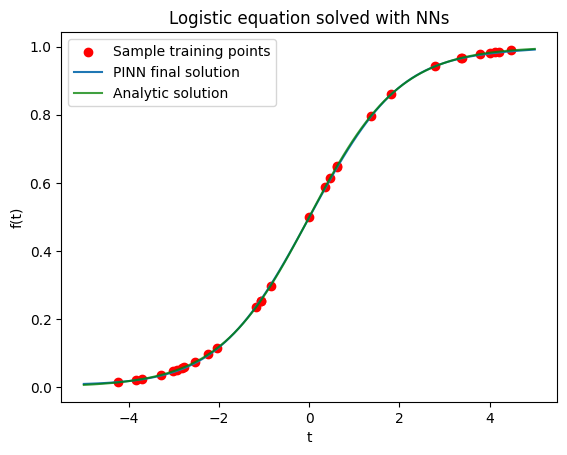

In [18]:
# plot solution on the given domain
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = f(x_eval, params)
analytical_sol_fn = lambda x: 1.0 / (1.0 + (1.0 / F_BOUNDARY - 1.0) * np.exp(-R * x))
x_eval_np = x_eval.detach().numpy()
x_sample_np = (
    torch.FloatTensor(batch_size).uniform_(domain[0], domain[1]).detach().numpy()
)

fig, ax = plt.subplots()

ax.scatter(
    x_sample_np,
    analytical_sol_fn(x_sample_np),
    color="red",
    label="Sample training points",
)
ax.plot(x_eval_np, f_eval.detach().numpy(), label="PINN final solution")
ax.plot(
    x_eval_np,
    analytical_sol_fn(x_eval_np),
    label=f"Analytic solution",
    color="green",
    alpha=0.75,
)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend();

In the plot above, the solution is evaluated on 100 uniformly spaced points, the evolution of the loss per each epoch (where the y-axis is in logarithmic scale) looks like this:

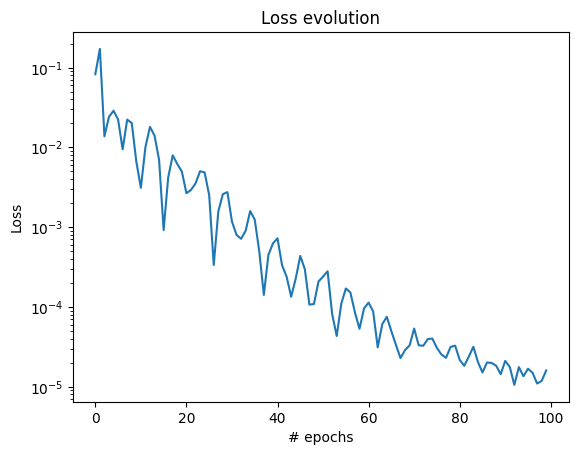

In [19]:
fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")

plt.show()

Here we solved a very simple, one dimensional problem. With more complex equations, convergence is not achieved so easily. Particularly for time-dependent problems, many useful tricks have been devised over the past years such as decomposing the solution domain in different parts solved using different neural networks, smart weighting of different loss contributions to avoid converging to trivial solutions and many more. I will introduce some of these tricks in future posts, so stay tuned.

This post gives a simple, high-level introduction to physics-informed neural networks, a promising machine learning method to solve (partial) differential equations. Although further advances are needed to make PINNs routinely applicable to industrial problems, they are a really active and exciting area of research and represent a promising alternative to standard differential equation solvers.